In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.2”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'coverm')

In [3]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/1_novel_strains/')
base_dir = ''#'full_run1/checkout/1_novel_strains/'

In [4]:
communities = gsub('^','marine',as.character(0:9))
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
motus,marine0


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 10920     7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006864318
singlem,marine0,phylum,Bray-Curtis distance,0.0199890488
singlem,marine0,class,Bray-Curtis distance,0.0234107741


[1] 5460    5

In [9]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 420   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006864318
singlem,marine0,phylum,Bray-Curtis distance,0.0199890488
singlem,marine0,class,Bray-Curtis distance,0.0234107741
singlem,marine0,order,Bray-Curtis distance,0.0363003897
singlem,marine0,family,Bray-Curtis distance,0.0424614261
singlem,marine0,genus,Bray-Curtis distance,0.0539140434
singlem,marine0,species,Bray-Curtis distance,0.1123290322
metaphlan,marine0,kingdom,Bray-Curtis distance,0.0000000000
metaphlan,marine0,phylum,Bray-Curtis distance,0.1179707555


In [10]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0006864318
singlem,marine0,phylum,Bray-Curtis distance,0.0199890488
singlem,marine0,class,Bray-Curtis distance,0.0234107741


In [11]:
average_bc = bc[, mean(value), by=list(tool)][order(V1)]
tool_order = average_bc$tool
bc[, tool := factor(tool, levels=tool_order)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


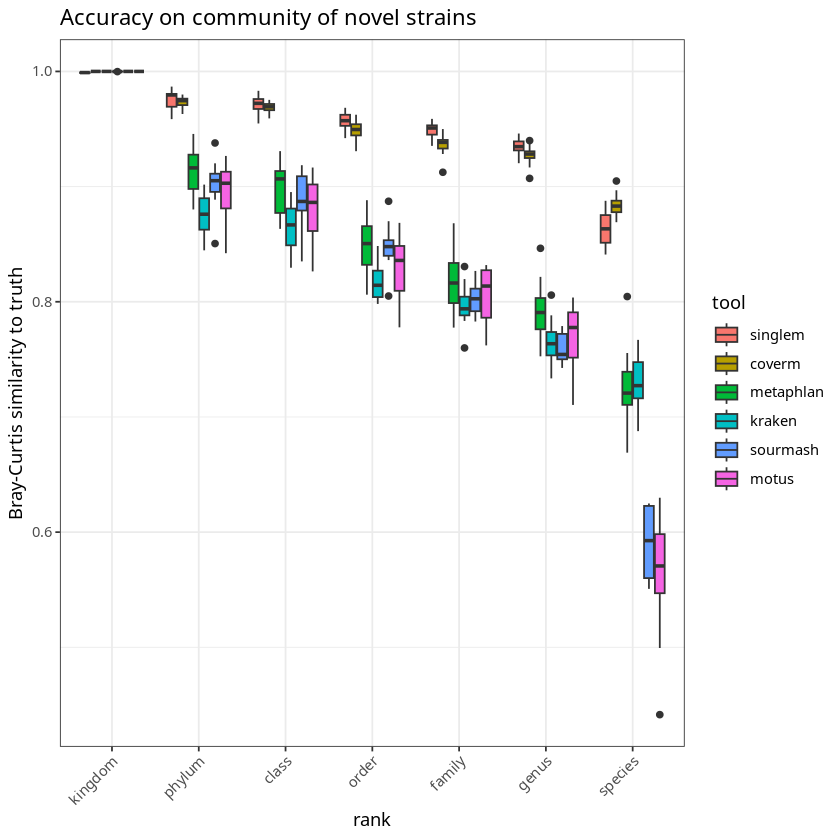

In [12]:
qplot(data=bc, rank, 1-value, geom='boxplot', fill=tool, ylab='Bray-Curtis similarity to truth', main='Accuracy on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [13]:
# How much better is singlem than the next best tool?
means = bc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
motus,0.4384909
sourmash,0.4094969
metaphlan,0.2722602
kraken,0.2721541
singlem,0.1365902
coverm,0.1155923


[1] 0.02099787

In [14]:
# write out bc
fwrite(bc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [15]:
thread_numbers = as.character(c(1,8,32))

In [16]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<fct>,<fct>
singlem,1,marine0
metaphlan,1,marine0
motus,1,marine0


In [17]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,5536.106,1:32:16,1612.55,3158.88,1587.71,1591.02,64.15,1495.66,83.78,346.71
metaphlan,1,marine0,24349.448,6:45:49,17523.12,18052.73,17485.55,17499.47,7.82,9705.83,106.70,94.03
motus,1,marine0,26097.818,7:14:57,10893.61,11030.97,10886.74,10887.10,0.00,0.01,101.56,406.26


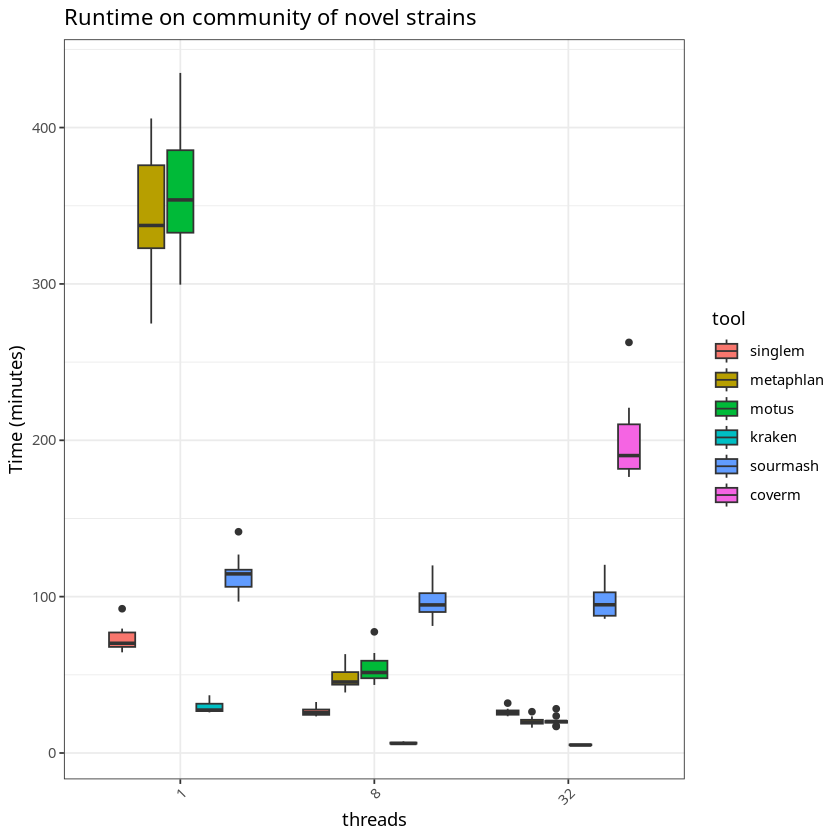

In [18]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

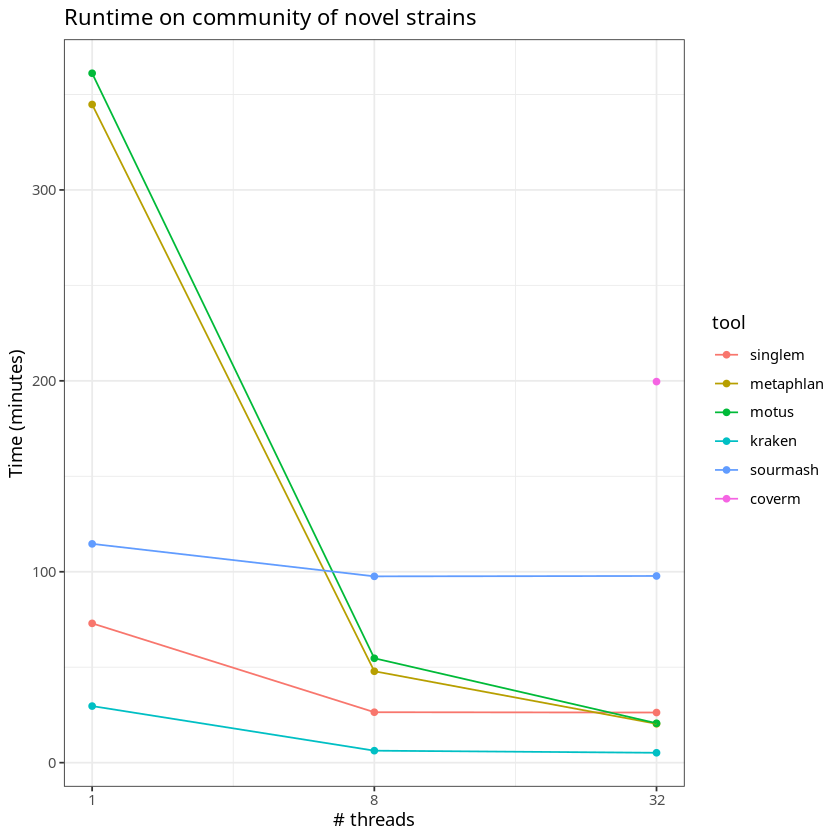

In [19]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

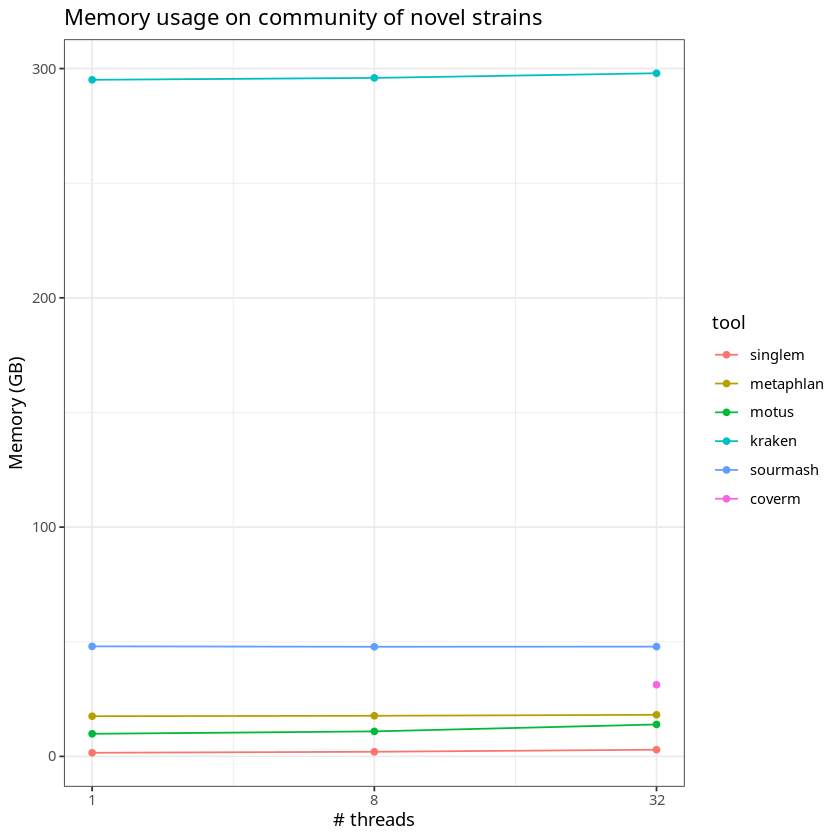

In [20]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [21]:
r4

tool,threads,mean_mem
<fct>,<fct>,<dbl>
singlem,1,1579.178
metaphlan,1,17525.802
motus,1,9853.306
kraken,1,295104.452
sourmash,1,47996.189
singlem,8,2014.938
metaphlan,8,17713.070
motus,8,10912.689
kraken,8,295936.022


In [24]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [25]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')

# Full set of stats of each method

In [47]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1[tool=='singlem', tool2 := 'SingleM']
s1[tool=='metaphlan', tool2 := 'MetaPhlAn']
s1[tool=='motus', tool2 := 'mOTUs']
s1[tool=='kraken', tool2 := 'Kraken2+Bracken']
s1[tool=='sourmash', tool2 := 'sourmash']
s1[tool=='kaiju', tool2 := 'Kaiju']
s1[tool=='coverm', tool2 := 'CoverM']
tools2_order = c('SingleM','MetaPhlAn','mOTUs','Kraken2+Bracken','sourmash','Kaiju','CoverM')
s1[, tool2 := factor(tool2, levels=tools2_order)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
s1[1:3]
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SingleM,kingdom,0.001029816,1,0.6666667,0,1,0.5,0.002059633,0.5,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
MetaPhlAn,kingdom,0.000000000,1,1.0000000,0,0,1.0,0.000000000,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
mOTUs,kingdom,0.000000000,1,1.0000000,0,0,1.0,0.000000000,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
